In [131]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
import numpy as np
import pandas as pd
import nibabel as nib
from tree_features import connectome_average, matrix_fusion, tree_connectivity, tree_dictionary, get_module_img
from io_functions import load_data
import os
import json
import glob
import inspect
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)


### Generate population-tree features for each given tree span and gamma parameter

In [133]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
sc_group = load_data(os.path.join(project_path, "sc"))
fc_group = load_data(os.path.join(project_path, "fc"))

In [137]:
fcm, scm = connectome_average(fc_group, sc_group)

In [37]:
g = 0.5
for g in np.arange(0, 1.1, 0.1):
    W = matrix_fusion(g, fcm, scm)
    tree_min = 10
    tree_max = 20
    t_dict = tree_dictionary(tree_min, tree_max, W)
    json.dump(t_dict, open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".json"), "w"))
    full_features = []
    for sc, fc in zip(sc_group, fc_group):
        t_features, t_features_names = tree_connectivity(tree_min, tree_max, W, sc, fc)
        full_features.append(t_features)

    full_df = pd.DataFrame(full_features)
    full_df.columns = t_features_names
    full_df = full_df.loc[:, ~full_df.apply(lambda x: x.duplicated(), axis=1).all()].copy()
#full_df.to_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".csv"), index=False)


### Store a nifti of a given module

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import json

project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
t_dictionary = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_0.5.json"), "r").read())
rois = t_dictionary['lvl_20_mod_3']

atlas = nib.load(os.path.join(project_path, "craddock_2128_2mm.nii.gz"))
atlas_data = atlas.get_fdata()
atlas_rois = np.where(atlas_data == (np.array(rois)+1), 1, 0).sum(axis=3)
atlas_rois_image = nib.Nifti1Image(atlas_rois, affine=atlas.affine)
nib.save(atlas_rois_image, os.path.join(project_path, "craddock_2128_2mm_lvl_20_mod_3.nii.gz"))


### Neuropsychological score prediction using population-tree features

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV, RFE
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict, GridSearchCV
from scipy import stats


#### Only training (cross-validation) using five different linear models

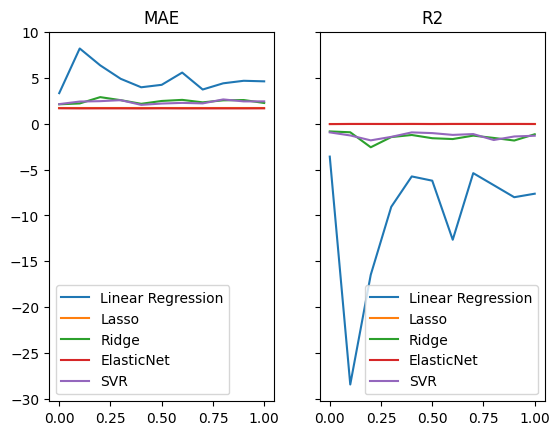

In [40]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
clf_1 = LinearRegression() 
clf_2 = Lasso() 
clf_3 = Ridge() 
clf_4 = ElasticNet() 
clf_5 = SVR(kernel='linear') 

list_clfs = [clf_1, clf_2, clf_3, clf_4, clf_5]
clas_names = ['Linear Regression', 'Lasso', 'Ridge','ElasticNet', 'SVR']
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()

fig, axs = plt.subplots(ncols=2, nrows=1, sharey=True, sharex=True)
for idx,clf in enumerate(list_clfs):
    mae_plot = []
    r2_plot = []
    for g in np.arange(0, 1.1, 0.1):
        df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".csv"))
        X = scaler.fit_transform(df)
        Y_pred = cross_val_predict(clf, X, y, cv=5)
        mae = mean_absolute_error(y, Y_pred)
        r2 = r2_score(y, Y_pred)
        mae_plot.append(mae)
        r2_plot.append(r2)

    axs[0].plot(np.arange(0, 1.1, 0.1), mae_plot, label=clas_names[idx])
    axs[0].set_title("MAE")
    axs[1].plot(np.arange(0, 1.1, 0.1), r2_plot, label=clas_names[idx])
    axs[1].set_title("R2")
axs[0].legend()
axs[1].legend()

### Generate brain maps with the best modules for each neuropsychological score prediction using multivariate RFE

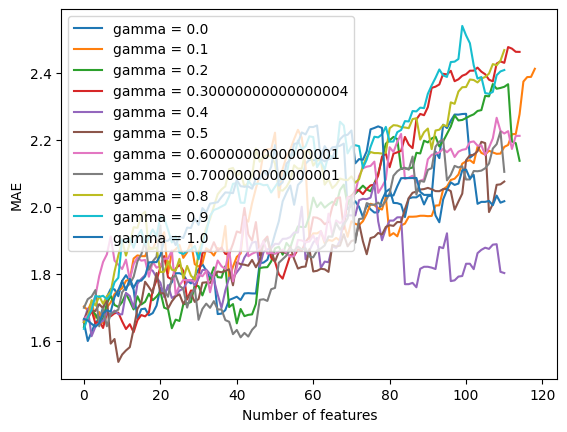

In [110]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
model = SVR(kernel='linear') 
#model = Ridge()
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()

for g in np.arange(0, 1.1, 0.1):
    df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".csv"))
    label_dict = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".json"), "r").read())
    X = scaler.fit_transform(df)

    selector = RFECV(model, step=1, cv=10, scoring='neg_mean_absolute_error')
    selector.fit(X, y)

    X_sorted = X[:, selector.ranking_-1]
    names_sorted = df.columns[selector.ranking_-1]

    mae = []
    for idx in range(1,len(selector.ranking_)):
        X_sub_samp = X_sorted[:, :idx]
        Y_pred = cross_val_predict(model, X_sub_samp, y, cv=10)
        mae.append(mean_absolute_error(y, Y_pred))

    plt.plot(mae, label="gamma = " + str(g))
    plt.xlabel("Number of features")
    plt.ylabel("MAE")
    plt.legend()  

    # min_mae_position = np.where(mae == np.min(mae))[0][0]
    # model_optimal = model.fit(X_sorted[:, :min_mae_position+1], y)
    # optimal_coeffs = model_optimal.coef_
    # optimal_modules = names_sorted[:min_mae_position+1]

    # atlas = nib.load(os.path.join(project_path, "craddock_2128_2mm.nii.gz"))
    # module_coef = []
    # for idx, mod in enumerate(optimal_modules):
    #     rois = label_dict[mod[6:]]
    #     module_coef.append(get_module_img(atlas, rois, abs(optimal_coeffs[idx])))

    # coeff_module_avg = np.array(module_coef).sum(axis=0)
    # coeff_module_img = nib.Nifti1Image(coeff_module_avg, affine=atlas.affine)
    #nib.save(coeff_module_img, os.path.join(project_path, "coeff_images", "multivariate",
    #    "ridge_coeffs_nf_" + str(len(optimal_coeffs)) + "_gamma_" + str(g) + ".nii.gz"))
#plt.savefig(os.path.join(project_path, "coeff_images", "multivariate",
#        "ridge_MAE.png"), dpi=300)

#### Best MAE for gamma = 0.2

Index(['SCINT_lvl_10_mod_1', 'SCEXT_lvl_10_mod_8', 'FCEXT_lvl_20_mod_15',
       'FCEXT_lvl_17_mod_8', 'SCINT_lvl_19_mod_9', 'FCEXT_lvl_10_mod_7',
       'SCINT_lvl_11_mod_7', 'SCEXT_lvl_17_mod_9', 'FCEXT_lvl_10_mod_8',
       'SCINT_lvl_10_mod_6'],
      dtype='object')

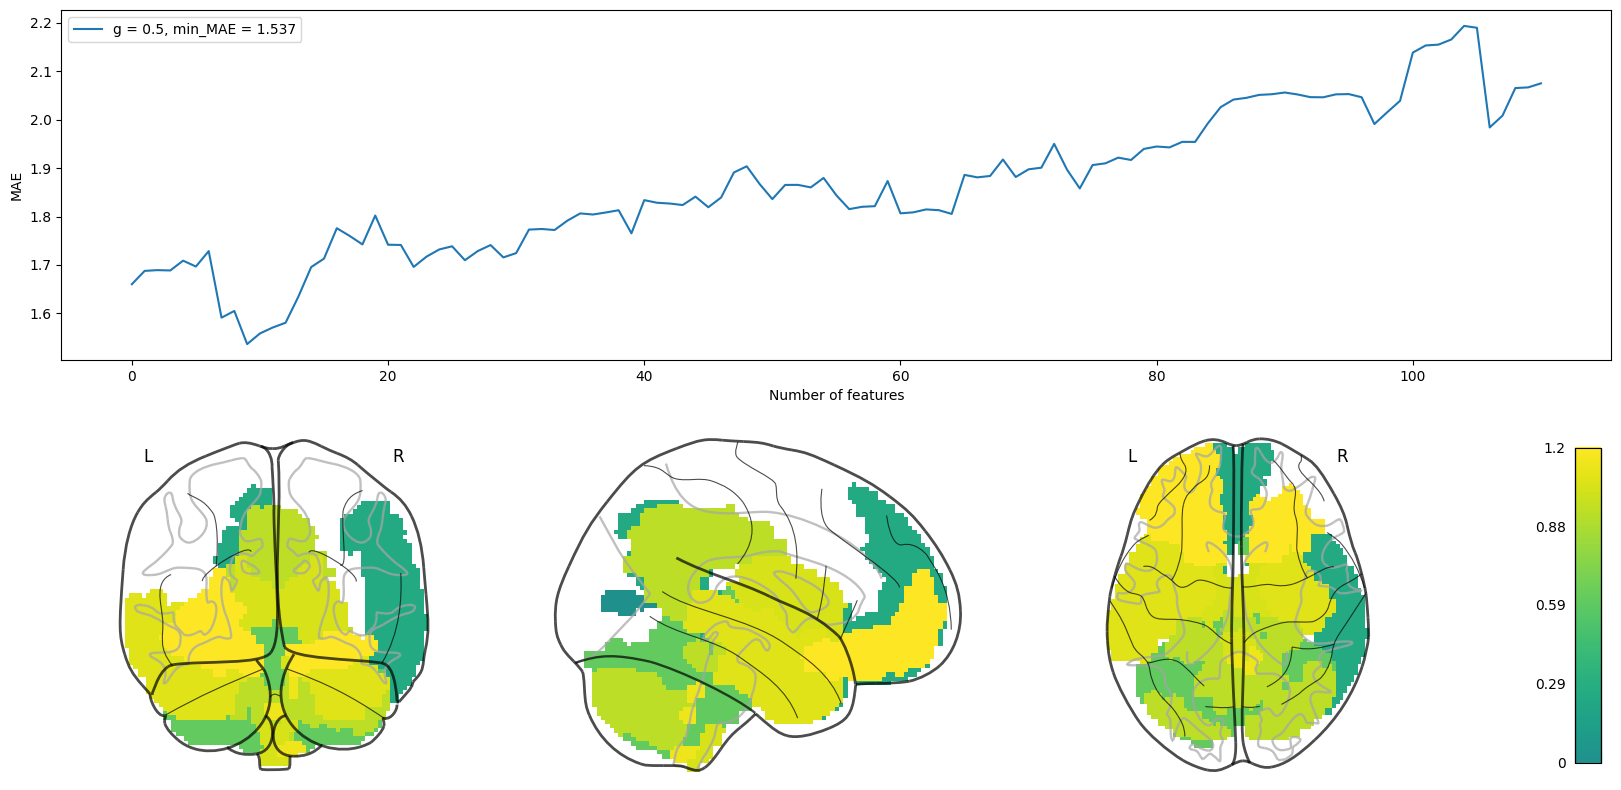

In [130]:
g=0.5
model = model = SVR(kernel='linear') 
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".csv"))
label_dict = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".json"), "r").read())
X = scaler.fit_transform(df)

selector = RFECV(model, step=1, cv=10, scoring='neg_mean_absolute_error')
selector.fit(X, y)

X_sorted = X[:, selector.ranking_-1]
names_sorted = df.columns[selector.ranking_-1]

mae = []
for idx in range(1,len(selector.ranking_)):
    X_sub_samp = X_sorted[:, :idx]
    Y_pred = cross_val_predict(model, X_sub_samp, y, cv=10)
    mae.append(mean_absolute_error(y, Y_pred))

min_mae_position = np.where(mae == np.min(mae))[0][0]
model_optimal = model.fit(X_sorted[:, :min_mae_position+1], y)
optimal_coeffs = model_optimal.coef_[0]
optimal_modules = names_sorted[:min_mae_position+1]

atlas = nib.load(os.path.join(project_path, "craddock_2128_2mm.nii.gz"))
module_coef = []
for idx, mod in enumerate(optimal_modules):
    rois = label_dict[mod[6:]]
    module_coef.append(get_module_img(atlas, rois, abs(optimal_coeffs[idx])))

coeff_module_avg = np.array(module_coef).sum(axis=0)
coeff_module_img = nib.Nifti1Image(coeff_module_avg, affine=atlas.affine)

#create a subplot
fig, ax = plt.subplots(2, 1)
ax[0].plot(mae, label="g = " + str(g) + ", min_MAE = " + str('%.3f'%np.min(mae)))
ax[0].set_xlabel("Number of features")
ax[0].set_ylabel("MAE")
ax[0].legend()  

plotting.plot_glass_brain(coeff_module_img, axes=ax[1], 
    colorbar = True, cmap='viridis')

optimal_modules

In [121]:
optimal_coeffs = model_optimal.coef_[0]
optimal_coeffs

array([ 0.00376208, -0.25767537,  0.67965545,  0.26957576, -0.08735827,
       -1.05956527,  0.11504266,  0.6856423 , -0.00448031,  0.34313664])

### Generate brain maps with the best modules for each neuropsychological score prediction using univariate correlation

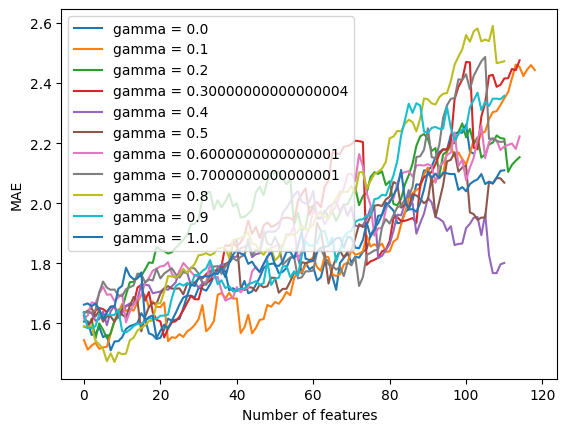

In [126]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"

for g in np.arange(0, 1.1, 0.1):
    model = SVR(kernel='linear')
    y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
        "CVLT",  "CVLT_zstuffed.txt"))
    scaler = StandardScaler()
    df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".csv"))
    label_dict = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".json"), "r").read())
    X = scaler.fit_transform(df)
    ft_corr = abs(np.corrcoef(X.T, y)[0:(len(X.T)),len(X.T)])

    X_sorted = X[:, np.argsort(ft_corr)[::-1]]
    names_sorted = df.columns[np.argsort(ft_corr)[::-1]]

    mae = []
    for idx in range(1,len(np.argsort(ft_corr)[::-1])):
        X_sub_samp = X_sorted[:, :idx]
        Y_pred = cross_val_predict(model, X_sub_samp, y, cv=10)
        mae.append(mean_absolute_error(y, Y_pred))

    plt.plot(mae, label="gamma = " + str(g))
    plt.xlabel("Number of features")
    plt.ylabel("MAE")
    plt.legend()   

    min_mae_position = np.where(mae == np.min(mae))[0][0]
    model_optimal = model.fit(X_sorted[:, :min_mae_position+1], y)
    optimal_coeffs = model_optimal.coef_[0]
    optimal_modules = names_sorted[:min_mae_position+1]

    atlas = nib.load(os.path.join(project_path, "craddock_2128_2mm.nii.gz"))
    module_coef = []
    for idx, mod in enumerate(optimal_modules):
        rois = label_dict[mod[6:]]
        module_coef.append(get_module_img(atlas, rois, abs(optimal_coeffs[idx])))

    coeff_module_avg = np.array(module_coef).sum(axis=0)
    coeff_module_img = nib.Nifti1Image(coeff_module_avg, affine=atlas.affine)
    nib.save(coeff_module_img, os.path.join(project_path, "coeff_images", "univariate",
        "SVR_lin_coeffs_nf_" + str(len(optimal_coeffs)) + "_gamma_" + str(g) + ".nii.gz"))

plt.savefig(os.path.join(project_path, "coeff_images", "univariate",
        "SVR_lin_MAE.png"), dpi=300)

#### Best MAE for gamma = 0.8

Index(['SCEXT_lvl_11_mod_2', 'SCEXT_lvl_10_mod_2', 'SCEXT_lvl_18_mod_3',
       'SCEXT_lvl_18_mod_2', 'SCINT_lvl_15_mod_7', 'FCEXT_lvl_10_mod_8',
       'SCINT_lvl_10_mod_6', 'FCINT_lvl_10_mod_8', 'SCINT_lvl_10_mod_9'],
      dtype='object')

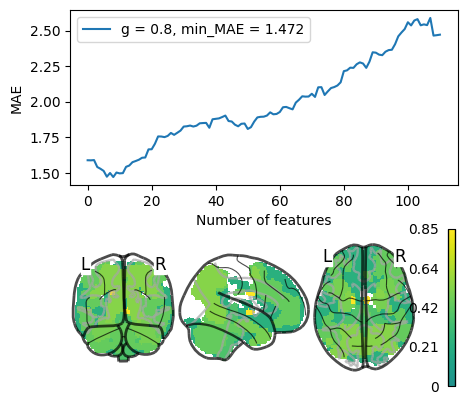

In [125]:
g=0.8
model = SVR(kernel='linear')
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".csv"))
label_dict = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".json"), "r").read())
X = scaler.fit_transform(df)
ft_corr = abs(np.corrcoef(X.T, y)[0:(len(X.T)),len(X.T)])

X_sorted = X[:, np.argsort(ft_corr)[::-1]]
names_sorted = df.columns[np.argsort(ft_corr)[::-1]]

mae = []
for idx in range(1,len(np.argsort(ft_corr)[::-1])):
    X_sub_samp = X_sorted[:, :idx]
    Y_pred = cross_val_predict(model, X_sub_samp, y, cv=10)
    mae.append(mean_absolute_error(y, Y_pred))

min_mae_position = np.where(mae == np.min(mae))[0][0]
model_optimal = model.fit(X_sorted[:, :min_mae_position+1], y)
optimal_coeffs = model_optimal.coef_[0]
optimal_modules = names_sorted[:min_mae_position+1]

atlas = nib.load(os.path.join(project_path, "craddock_2128_2mm.nii.gz"))
module_coef = []
for idx, mod in enumerate(optimal_modules):
    rois = label_dict[mod[6:]]
    module_coef.append(get_module_img(atlas, rois, abs(optimal_coeffs[idx])))

coeff_module_avg = np.array(module_coef).sum(axis=0)
coeff_module_img = nib.Nifti1Image(coeff_module_avg, affine=atlas.affine)

#create a subplot
fig, ax = plt.subplots(2, 1, figsize=(5, 5))
ax[0].plot(mae, label="g = " + str(g) + ", min_MAE = " + str('%.3f'%np.min(mae)))
ax[0].set_xlabel("Number of features")
ax[0].set_ylabel("MAE")
ax[0].legend()  

plotting.plot_glass_brain(coeff_module_img, axes=ax[1], 
    colorbar = True, cmap='viridis')

optimal_modules

#### SVR with gridsearch CV as model

In [164]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
C_vals = np.logspace(-3,3, num=20)
gamma_vals = np.logspace(-2,-1, num=5)
tuning_parameters = [{'kernel': ['rbf'], 
                     'gamma': gamma_vals,
                     'C': C_vals},
                    {'kernel': ['linear'], 
                     'C': C_vals},
                    {'kernel': ['poly'],
                     'gamma': gamma_vals,
                     'degree' : [2, 3],
                     'C': C_vals},
                    {'kernel': ['sigmoid'],
                     'gamma': gamma_vals,
                     'C': C_vals}]
est = SVR()

for g in np.arange(0, 1.1, 0.1):
    y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
        "CVLT",  "CVLT_zstuffed.txt"))
    scaler = StandardScaler()
    df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".csv"))
    label_dict = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".json"), "r").read())
    X = scaler.fit_transform(df)
    ft_corr = abs(np.corrcoef(X.T, y)[0:(len(X.T)),len(X.T)])

    X_sorted = X[:, np.argsort(ft_corr)[::-1]]
    names_sorted = df.columns[np.argsort(ft_corr)[::-1]]

    mae = []
    #for idx in range(1,len(np.argsort(ft_corr)[::-1])):
    for idx in range(1,30):
        print(idx)
        X_sub_samp = X_sorted[:, :idx]
        gs = GridSearchCV(est, param_grid=tuning_parameters, cv=10, 
            scoring="neg_mean_absolute_error").fit(X_sub_samp, y)
        model = gs.best_estimator_
        Y_pred = cross_val_predict(model, X_sub_samp, y, cv=10)
        mae.append(mean_absolute_error(y, Y_pred))

    plt.plot(mae, label="gamma = " + str(g))
    plt.xlabel("Number of features")
    plt.ylabel("MAE")
    plt.legend()   

    

KeyboardInterrupt: 